In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import re

import statsmodels.formula.api as statf
from linearmodels import PanelOLS
from sklearn.decomposition import PCA

import pyreadr

In [2]:
df = pd.read_csv('D:/HSE/5/Проект/Данные/Mass Mobilization Protest Data/mmALL_020619_v15.csv', engine='python')
df = df.iloc[:,1:]
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001.0,Canada,20,1990,3,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Great Canadian train journeys into history;...,NaN
1,201990002.0,Canada,20,1990,3,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Autonomy s Cry Revived in Quebec The New Yo...,NaN
2,201990003.0,Canada,20,1990,3,1,3,1.0,7.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201990004.0,Canada,20,1990,3,1,4,12.0,7.0,1990.0,...,NaN,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201990005.0,Canada,20,1990,3,1,5,14.0,8.0,1990.0,...,NaN,crowd dispersal,arrests,accomodation,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
main_columns = df.columns[:15].append(df.columns[16:19].append(df.columns[22:23]))
main_columns

Index(['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants', 'protesteridentity',
       'protesterdemand1', 'stateresponse1'],
      dtype='object')

In [4]:
df.shape

(15570, 31)

### Удаляем наблюдения с пропускам по главным переменным

In [5]:
df = df.dropna(subset=main_columns).reset_index(drop=True)
df.shape

(13150, 31)

### Создаем переменную длительность протеста в днях

In [6]:
df.loc[:, df.columns[7:14]] = df.loc[:, df.columns[7:14]].astype(float).astype(int)
df_start = df.loc[:,['startday', 'startmonth', 'startyear']]
df_start = df_start.rename(columns = {'startday':'day', 'startmonth':'month', 'startyear':'year'})

df_end = df.loc[:,['endday', 'endmonth', 'endyear']]
df_end = df_end.rename(columns = {'endday':'day', 'endmonth':'month', 'endyear':'year'})

In [7]:
df['startdate'] = pd.to_datetime(df_start)
df['enddate'] = pd.to_datetime(df_end)
df['duration_days'] = df['enddate'].subtract(df['startdate']).dt.days+1
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,startdate,enddate,duration_days
0,201990001.0,Canada,20,1990,3,1,1,15,1,1990,...,NaN,NaN,NaN,NaN,NaN,1. Great Canadian train journeys into history;...,NaN,1990-01-15,1990-01-15,1
1,201990002.0,Canada,20,1990,3,1,2,25,6,1990,...,NaN,NaN,NaN,NaN,NaN,1. Autonomy s Cry Revived in Quebec The New Yo...,NaN,1990-06-25,1990-06-25,1
2,201990003.0,Canada,20,1990,3,1,3,1,7,1990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-07-01,1990-07-01,1
3,201990004.0,Canada,20,1990,3,1,4,12,7,1990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-07-12,1990-09-06,57
4,201990005.0,Canada,20,1990,3,1,5,14,8,1990,...,accomodation,NaN,NaN,NaN,NaN,NaN,NaN,1990-08-14,1990-08-15,2


### Перекодируем требования протестующих

In [8]:
df['protesterdemand1'].value_counts()

political behavior, process    8391
labor wage dispute             1571
price increases, tax policy     936
removal of politician           796
police brutality                678
land farm issue                 409
social restrictions             369
Name: protesterdemand1, dtype: int64

In [9]:
def label_category_demands(row):
    if row['protesterdemand1'] in ['political behavior, process', 'removal of politician']:
        return 'political'
    if row['protesterdemand1'] in ['police brutality', 'social restrictions']:
        return 'social'
    if row['protesterdemand1'] in ['labor wage dispute', 'price increases, tax policy', 'land farm issue']:
        return 'economic'
    
def label_level_demands(row):
    if row['protesterdemand1'] in ['political behavior, process', 'removal of politician']:
        return 2
    if row['protesterdemand1'] in ['police brutality', 'social restrictions']:
        return 1
    if row['protesterdemand1'] in ['labor wage dispute', 'price increases, tax policy', 'land farm issue']:
        return 0

In [10]:
df['demand_type'] = df.apply(lambda row:label_category_demands(row), axis=1)
df['demand_level'] = df.apply(lambda row:label_level_demands(row), axis=1)
df = pd.get_dummies(df, columns=['demand_type'])
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,stateresponse7,sources,notes,startdate,enddate,duration_days,demand_level,demand_type_economic,demand_type_political,demand_type_social
0,201990001.0,Canada,20,1990,3,1,1,15,1,1990,...,NaN,1. Great Canadian train journeys into history;...,NaN,1990-01-15,1990-01-15,1,2,0,1,0
1,201990002.0,Canada,20,1990,3,1,2,25,6,1990,...,NaN,1. Autonomy s Cry Revived in Quebec The New Yo...,NaN,1990-06-25,1990-06-25,1,2,0,1,0
2,201990003.0,Canada,20,1990,3,1,3,1,7,1990,...,NaN,NaN,NaN,1990-07-01,1990-07-01,1,2,0,1,0
3,201990004.0,Canada,20,1990,3,1,4,12,7,1990,...,NaN,NaN,NaN,1990-07-12,1990-09-06,57,0,1,0,0
4,201990005.0,Canada,20,1990,3,1,5,14,8,1990,...,NaN,NaN,NaN,1990-08-14,1990-08-15,2,2,0,1,0


### Перекодируем реакцию государства на протесты

In [11]:
def label_state_response(row):
    if row in ['accomodation']:
        return 3
    if row in ['ignore']:
        return 2
    if row in ['crowd dispersal', 'arrests']:
        return 1
    if row in ['killings', 'beatings', 'shootings']:
        return 0

In [12]:
#df = df[df['stateresponse2'].isnull()] удалим все наблюдению, в которых реакция государтва на протесты была многогранной

In [13]:
df['st_response_1'] = df.apply(lambda row:label_state_response(row['stateresponse1']), axis=1)
df['st_response_2'] = df.apply(lambda row:label_state_response(row['stateresponse2']), axis=1)
df['st_response_3'] = df.apply(lambda row:label_state_response(row['stateresponse3']), axis=1)
df['st_response_4'] = df.apply(lambda row:label_state_response(row['stateresponse4']), axis=1)
df['st_response_5'] = df.apply(lambda row:label_state_response(row['stateresponse5']), axis=1)
df['st_response_6'] = df.apply(lambda row:label_state_response(row['stateresponse6']), axis=1)
df['st_response_7'] = df.apply(lambda row:label_state_response(row['stateresponse7']), axis=1)

In [14]:
df['stateresponse1'].value_counts(dropna=False)

ignore             7246
crowd dispersal    3273
arrests             966
accomodation        814
shootings           357
beatings            293
killings            201
Name: stateresponse1, dtype: int64

In [15]:
df['stateresponse2'].value_counts(dropna=False)

NaN                10719
arrests              623
crowd dispersal      522
accomodation         344
beatings             341
shootings            306
killings             268
ignore                27
Name: stateresponse2, dtype: int64

In [16]:
df['stateresponse3'].value_counts(dropna=False)

NaN                12393
arrests              201
crowd dispersal      172
killings             152
accomodation          84
beatings              74
shootings             66
ignore                 8
Name: stateresponse3, dtype: int64

#### !проблема: государство может на протест сразу ответить несколькими действиями

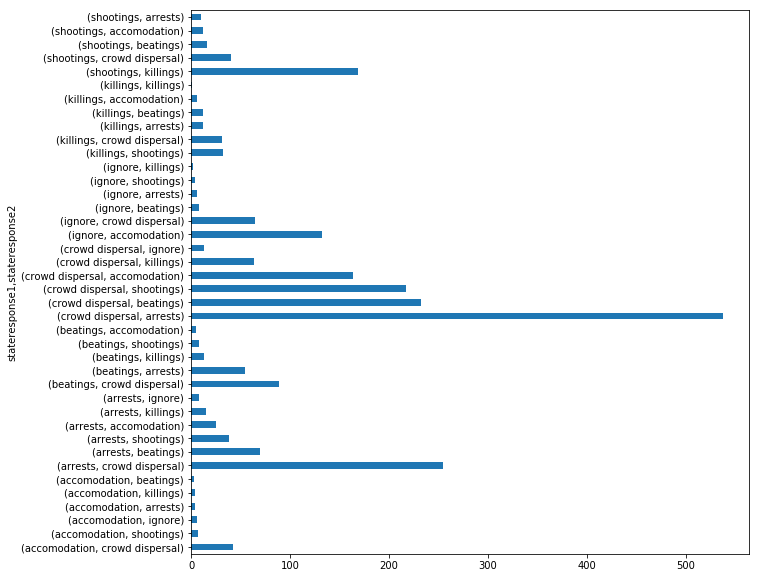

In [17]:
a = df.groupby(['stateresponse1'])
mp.figure(figsize=(10,10))
a['stateresponse2'].value_counts().plot(kind='barh')

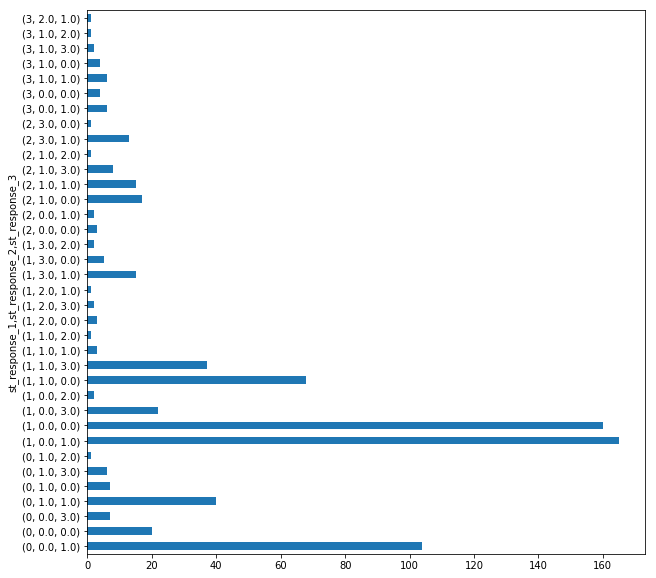

In [18]:
a = df.groupby(['st_response_1', 'st_response_2'])
mp.figure(figsize=(10,10))
a['st_response_3'].value_counts().plot(kind='barh')

### Закодируем социальную гетерогенность протеста, исходя из состава участников

In [19]:
df['protesteridentity'].value_counts()[:10]

protesters               1226
students                  458
unspecified               223
workers                   213
farmers                   182
Students                  142
residents                 121
demonstrators             121
university students       118
opposition supporters     103
Name: protesteridentity, dtype: int64

In [20]:
heterogeneity_groups = ['protesters', 'unspecified', 'residents', 'demonstrators', 'opposition supporters', 'Protesters',
                       'People', 'opposition', 'locals', 'local residents', 'Chaves  opponents', 'Opposition supporters',
                       'anti corruption protesters', 'Protestors', 'Residents', 'Opposition', 'people', 'pro democracy',
                       'opposition parties', 'opposition activists', 'protestors', 'Opposition Parties    Supporters',
                       'Opposition Supporters', 'Brazilians', 'Demonstrators', 'public', 'Greeks', 'anti government',
                       'opposition parties members and supporters', 'anti government protesters, opposition supporters,\
                       Union of Democratic Forces  UDF ', 'opposition demonstrators', 'Pro Democracy Demonstrators', 
                       'Pro Democracy Activists', 'pro democracy protesters', 'Serbs', 'opposition protesters',
                       'opposition protesters', 'protesters ']
def label_heterogeneity(row):
    if row.strip() in heterogeneity_groups or ',' in row:
        return 1
    else:
        return 0

In [21]:
df['heterogeneity'] = df.apply(lambda row: label_heterogeneity(row['protesteridentity']), axis = 1)
df['heterogeneity'].value_counts()

0    9292
1    3858
Name: heterogeneity, dtype: int64

### Подчистим данные о численности протеста

In [22]:
df['participants'].value_counts(dropna=False)[:20]

100s        1087
1000s       1006
50+          965
>50          924
1000         902
50           879
100          764
10000        377
200          362
2000         313
100+         286
300          263
500          251
5000         226
3000         216
10000s       187
20000        163
hundreds     126
150          123
4000         118
Name: participants, dtype: int64

In [23]:
df['participants_category'].value_counts(dropna=False)

NaN           4758
100-999       2789
50-99         2209
2000-4999     1366
>10000        1120
5000-10000     474
1000-1999      434
Name: participants_category, dtype: int64

In [24]:
df[df['participants_category'].isnull()]['participants'].value_counts(dropna=False)[:10]

1000     717
50       593
100      543
10000    256
100s     252
1000s    187
2000     166
200      161
500      137
3000     128
Name: participants, dtype: int64

In [25]:
def number_protest(row):
    if '-' in row['participants']:
        return int(''.join(filter(lambda x: x.isdigit(), row['participants'][row['participants'].index('-')+1:])))
    
    if ' and ' in row['participants']:
        try:
            return int(''.join(filter(lambda x: x.isdigit(), row['participants'][row['participants'].index('and')+1:])))
        except:
            np.nan
    
    if ''.join(filter(lambda x: x.isdigit(), row['participants']))=='':
        if pd.isnull(row['participants_category'])==False:
            try:
                return ''.join(filter(lambda x: x.isdigit(), row['participants_category'][row['participants_category'].index('-')+1:]))
            except:
                return ''.join(filter(lambda x: x.isdigit(), row['participants_category'][row['participants_category'].index('>')+1:]))
        else:
            return np.nan

    else:
        return int(''.join(filter(lambda x: x.isdigit(), row['participants'])))

In [26]:
df.loc[1169, 'participants']

'Protesters on whom the government security forces used water cannons, rubber bullets and batons'

In [27]:
df['number_participants'] = df.apply(lambda row: number_protest(row), axis = 1)
df = df.dropna(subset=['number_participants']).reset_index(drop=True)
df['number_participants'] = df['number_participants'].astype(np.int64)

### Создадим переменную, отражающую национальный масштаб протеста

In [28]:
df['nation_level'] = np.where(df['location'].str.contains('nation', flags=re.IGNORECASE),1,0)
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,st_response_1,st_response_2,st_response_3,st_response_4,st_response_5,st_response_6,st_response_7,heterogeneity,number_participants,nation_level
0,201990001.0,Canada,20,1990,3,1,1,15,1,1990,...,2,NaN,NaN,NaN,NaN,NaN,NaN,1,1000,1
1,201990002.0,Canada,20,1990,3,1,2,25,6,1990,...,2,NaN,NaN,NaN,NaN,NaN,NaN,1,1000,0
2,201990003.0,Canada,20,1990,3,1,3,1,7,1990,...,2,NaN,NaN,NaN,NaN,NaN,NaN,0,500,0
3,201990004.0,Canada,20,1990,3,1,4,12,7,1990,...,3,NaN,NaN,NaN,NaN,NaN,NaN,0,100,0
4,201990005.0,Canada,20,1990,3,1,5,14,8,1990,...,1,1.0,3.0,NaN,NaN,NaN,NaN,1,950,0


In [29]:
df.shape

(13145, 48)

### Создадим лагированный отклик на прошлый протест и на моду прошлого месяца + переменную последовательности действий властей

In [30]:
df = df.sort_values(by=['country','startdate']).reset_index(drop=True)

In [31]:
df['st_response_1_lag_1event'] = df.groupby('country')['st_response_1'].shift(1)
df['st_response_1_lag_2event'] = df.groupby('country')['st_response_1'].shift(2)

In [32]:
sum(df.groupby('country')['st_response_1'].shift(1).isnull())

166

In [33]:
len(set(df.country))

166

In [34]:
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,st_response_3,st_response_4,st_response_5,st_response_6,st_response_7,heterogeneity,number_participants,nation_level,st_response_1_lag_1event,st_response_1_lag_2event
0,7.001997e+09,Afghanistan,700,1997,5,1,1,23,12,1997,...,NaN,NaN,NaN,NaN,NaN,0,2000,0,NaN,NaN
1,7.002002e+09,Afghanistan,700,2002,5,1,1,11,11,2002,...,NaN,NaN,NaN,NaN,NaN,0,200,0,2.0,NaN
2,7.002005e+09,Afghanistan,700,2005,5,1,1,5,5,2005,...,NaN,NaN,NaN,NaN,NaN,0,200,0,1.0,2.0
3,7.002005e+09,Afghanistan,700,2005,5,1,2,31,10,2005,...,NaN,NaN,NaN,NaN,NaN,0,200,0,2.0,1.0
4,7.002011e+09,Afghanistan,700,2011,5,1,3,19,5,2011,...,NaN,NaN,NaN,NaN,NaN,1,100,0,2.0,2.0


In [35]:
df['startmonth'] = df['startdate'].dt.to_period('M')

In [36]:
df_mode_month = pd.DataFrame(df.groupby(['country', 'startmonth'])['st_response_1'].agg(lambda x:x.value_counts().index[0]))\
.reset_index(drop=False)
df_mode_month['st_response_1_lag_1mnth'] = df_mode_month.groupby('country')['st_response_1'].shift(1)
df_mode_month['st_response_1_lag_2mnth'] = df_mode_month.groupby('country')['st_response_1'].shift(2)
df_mode_month.head()

,country,startmonth,st_response_1,st_response_1_lag_1mnth,st_response_1_lag_2mnth
0,Afghanistan,1997-12,2,NaN,NaN
1,Afghanistan,2002-11,1,2.0,NaN
2,Afghanistan,2005-05,2,1.0,2.0
3,Afghanistan,2005-10,2,2.0,1.0
4,Afghanistan,2011-05,1,2.0,2.0


In [37]:
sum(df_mode_month['st_response_1_lag_1mnth'].isnull())

166

In [38]:
df = pd.merge(df, df_mode_month.drop('st_response_1', axis=1), how='left', on=['country', 'startmonth'])

In [39]:
sum(df['st_response_1_lag_1event'] != df['st_response_1_lag_1mnth'])

3185

In [40]:
df['inconsistency_event'] = (df['st_response_1_lag_1event'] != df['st_response_1_lag_2event']).astype(int)

In [41]:
df['inconsistency_mnth'] = (df['st_response_1_lag_1mnth'] != df['st_response_1_lag_2mnth']).astype(int)
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,st_response_7,heterogeneity,number_participants,nation_level,st_response_1_lag_1event,st_response_1_lag_2event,st_response_1_lag_1mnth,st_response_1_lag_2mnth,inconsistency_event,inconsistency_mnth
0,7.001997e+09,Afghanistan,700,1997,5,1,1,23,1997-12,1997,...,NaN,0,2000,0,NaN,NaN,NaN,NaN,1,1
1,7.002002e+09,Afghanistan,700,2002,5,1,1,11,2002-11,2002,...,NaN,0,200,0,2.0,NaN,2.0,NaN,1,1
2,7.002005e+09,Afghanistan,700,2005,5,1,1,5,2005-05,2005,...,NaN,0,200,0,1.0,2.0,1.0,2.0,1,1
3,7.002005e+09,Afghanistan,700,2005,5,1,2,31,2005-10,2005,...,NaN,0,200,0,2.0,1.0,2.0,1.0,1,1
4,7.002011e+09,Afghanistan,700,2011,5,1,3,19,2011-05,2011,...,NaN,1,100,0,2.0,2.0,2.0,2.0,0,0


### Добавим контрольные переменные

In [42]:
qog = pd.read_csv('D:/HSE/5/Проект/Данные/QoG/qog_std_ts_jan19.csv', engine='python')
qog.head()

,ccode,cname,year,ccodealp,cname_year,ccodealp_year,ccodecow,ccodewb,version,aid_cpnc,...,wwbi_rrespubpemp,wwbi_sprpempn,wwbi_sprpempp,wwbi_sprpemps,wwbi_sprpempt,wwbi_spupempn,wwbi_spupempp,wwbi_spupemps,wwbi_spupempt,wwbi_tertiarypubsec
0,4,Afghanistan,1946,AFG,Afghanistan 1946,AFG46,700.0,4.0,QoGStdTSJan19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,Afghanistan,1947,AFG,Afghanistan 1947,AFG47,700.0,4.0,QoGStdTSJan19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,Afghanistan,1948,AFG,Afghanistan 1948,AFG48,700.0,4.0,QoGStdTSJan19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Afghanistan,1949,AFG,Afghanistan 1949,AFG49,700.0,4.0,QoGStdTSJan19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Afghanistan,1950,AFG,Afghanistan 1950,AFG50,700.0,4.0,QoGStdTSJan19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
qog_data = qog[['cname', 'year', 'ccodealp', 'cname_year', 'ccodealp_year',
                'wdi_gdpcappppcon2011', 'wdi_gdppppcon2011',
                'vdem_delibdem', 'vdem_egaldem', 'vdem_libdem', 'vdem_polyarchy', 'vdem_partipdem',
                'wbgi_cce', 'wbgi_gee', 'wbgi_pve', 'wbgi_rle', 'wbgi_vae', 'wbgi_rqe',
                'wdi_precip', 'wdi_popden',
                'ht_regtype',
                'al_ethnic', 'fe_cultdiv', 'fe_etfra',]]

In [44]:
x = qog_data.set_index('cname_year')

In [45]:
x.loc['Ethiopia (1993-) 1990', x.columns[4:19]] = x.loc['Ethiopia (-1992) 1990', x.columns[4:19]].values
x.loc['Ethiopia (1993-) 1991', x.columns[4:19]] = x.loc['Ethiopia (-1992) 1991', x.columns[4:19]].values
x.loc['Ethiopia (1993-) 1992', x.columns[4:19]] = x.loc['Ethiopia (-1992) 1992', x.columns[4:19]].values

x.loc['Sudan (-2011) 2012', x.columns[4:19]] = x.loc['Sudan (2012-) 2012', x.columns[4:19]].values
x.loc['Sudan (-2011) 2013', x.columns[4:19]] = x.loc['Sudan (2012-) 2013', x.columns[4:19]].values
x.loc['Sudan (-2011) 2014', x.columns[4:19]] = x.loc['Sudan (2012-) 2014', x.columns[4:19]].values
x.loc['Sudan (-2011) 2015', x.columns[4:19]] = x.loc['Sudan (2012-) 2015', x.columns[4:19]].values
x.loc['Sudan (-2011) 2016', x.columns[4:19]] = x.loc['Sudan (2012-) 2016', x.columns[4:19]].values
x.loc['Sudan (-2011) 2017', x.columns[4:19]] = x.loc['Sudan (2012-) 2017', x.columns[4:19]].values
x.loc['Sudan (-2011) 2018', x.columns[4:19]] = x.loc['Sudan (2012-) 2018', x.columns[4:19]].values

qog_data = x.reset_index(drop=False)

In [46]:
qog_data['wdi_precip'] = qog_data.groupby('cname')['wdi_precip'].apply(lambda x: x.fillna(x.median()))

In [47]:
qog_data_vdem = qog_data.dropna(subset=['vdem_delibdem', 'vdem_egaldem', 'vdem_libdem', 'vdem_polyarchy', 'vdem_partipdem'])
pca = PCA(n_components=1)
qog_data_vdem['vdem_pca'] = pca.fit_transform(qog_data_vdem[['vdem_delibdem', 'vdem_egaldem', 'vdem_libdem', 'vdem_polyarchy',
                                                             'vdem_partipdem']].values)
print(pca.explained_variance_ratio_)

[0.97511407]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:
qog_data_wgi = qog_data.dropna(subset=['wbgi_cce', 'wbgi_gee', 'wbgi_pve', 'wbgi_rle', 'wbgi_vae', 'wbgi_rqe'])
pca = PCA(n_components=1)
qog_data_wgi['wgi_pca'] = pca.fit_transform(qog_data_wgi[['wbgi_cce', 'wbgi_gee', 'wbgi_pve', 'wbgi_rle', 'wbgi_vae',
                                                             'wbgi_rqe']].values)
print(pca.explained_variance_ratio_)

[0.84499609]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [49]:
qog_data = pd.merge(qog_data, qog_data_vdem[['cname_year','vdem_pca']], how='left', on='cname_year')
qog_data = pd.merge(qog_data, qog_data_wgi[['cname_year','wgi_pca']], how='left', on='cname_year')

In [50]:
col_qog = ['cname', 'year', 'ccodealp', 'cname_year', 'ccodealp_year',
           'wdi_gdpcappppcon2011', 'wdi_gdppppcon2011', 'vdem_pca', 'wgi_pca', 'ht_regtype', 'al_ethnic',
           'fe_cultdiv', 'fe_etfra', 'wdi_precip', 'wdi_popden']

df['country'] = df['country'].replace('United Arab Emirate', 'United Arab Emirates')
df['country'] = df['country'].replace('North Korea', 'Korea, North')
df['country'] = df['country'].replace('Congo Brazzaville', 'Congo')
df['country'] = df['country'].replace('Congo Kinshasa', 'Congo, Democratic Republic')
df['country'] = df['country'].replace('Germany West', 'Germany, West')
df['country'] = df['country'].replace('Germany East', 'Germany, East')
df['country'] = df['country'].replace('Ivory Coast', "Cote d'Ivoire")
df['country'] = df['country'].replace('Timor Leste', 'Timor-Leste')
df['country'] = df['country'].replace('Slovak Republic', 'Slovakia')
df['country'] = df['country'].replace('Bosnia', 'Bosnia and Herzegovina')
df['country'] = df['country'].replace('Swaziland', 'Eswatini (former Swaziland)')
df['country'] = df['country'].replace('South Korea', 'Korea, South')

qog_data['cname'] = qog_data['cname'].replace('Cyprus (1975-)', 'Cyprus')
qog_data['cname'] = qog_data['cname'].replace('France (1963-)', 'France')
qog_data['cname'] = qog_data['cname'].replace('Malaysia (1966-)', 'Malaysia')
qog_data['cname'] = qog_data['cname'].replace('Pakistan (1971-)', 'Pakistan')
qog_data['cname'] = qog_data['cname'].replace('Sudan (-2011)', 'Sudan')
qog_data['cname'] = qog_data['cname'].replace('Ethiopia (1993-)', 'Ethiopia')

print(set(qog_data['cname'])-set(df['country'])) # нет в df
print(set(df['country'])-set(qog_data['cname'])) # нет в qog

{'New Zealand', 'Ethiopia (-1992)', 'San Marino', 'Seychelles', 'Monaco', 'Sao Tome and Principe', 'Australia', 'France (-1962)', 'Palau', 'Grenada', 'Samoa', 'Vanuatu', 'Sudan (2012-)', 'Tuvalu', 'Malaysia (-1965)', 'Israel', 'Andorra', 'Pakistan (-1970)', 'Nauru', 'St Vincent and the Grenadines', 'Iceland', 'Cyprus (-1974)', 'Dominica', 'Tonga', 'Antigua and Barbuda', 'Fiji', 'Yemen, South', 'St Kitts and Nevis', 'Vietnam, South', 'Brunei', 'Kiribati', 'Liechtenstein', 'Trinidad and Tobago', 'Tibet', 'Bahamas', 'Maldives', 'Micronesia', 'United States', 'Malta', 'Barbados', 'St Lucia', 'Yemen, North', 'Solomon Islands', 'Belize', 'Vietnam, North', 'Marshall Islands'}
{'Kosovo'}


In [51]:
df['cname_year'] = df['country']+' '+df['year'].astype(str)
qog_data['cname_year'] = qog_data['cname']+' '+qog_data['year'].astype(str)
df = pd.merge(df, qog_data[col_qog].drop('year', axis=1), how = 'left', on = 'cname_year')
df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,wdi_gdpcappppcon2011,wdi_gdppppcon2011,vdem_pca,wgi_pca,ht_regtype,al_ethnic,fe_cultdiv,fe_etfra,wdi_precip,wdi_popden
0,7.001997e+09,Afghanistan,700,1997,5,1,1,23,1997-12,1997,...,NaN,NaN,-0.685097,NaN,21.0,0.769345,0.679267,0.750797,327.0,28.155508
1,7.002002e+09,Afghanistan,700,2002,5,1,1,11,2002-11,2002,...,1063.635574,2.337863e+10,-0.400648,3.797031,20.0,0.769345,0.679267,0.750797,327.0,33.667131
2,7.002005e+09,Afghanistan,700,2005,5,1,1,5,2005-05,2005,...,1136.123214,2.848352e+10,-0.269189,3.540971,1.0,0.769345,0.679267,0.750797,327.0,38.401492
3,7.002005e+09,Afghanistan,700,2005,5,1,2,31,2005-10,2005,...,1136.123214,2.848352e+10,-0.269189,3.540971,1.0,0.769345,0.679267,0.750797,327.0,38.401492
4,7.002011e+09,Afghanistan,700,2011,5,1,3,19,2011-05,2011,...,1660.739856,4.933825e+10,-0.193133,3.999987,1.0,0.769345,0.679267,0.750797,327.0,45.505314


In [102]:
df[['country', 'location', 'startdate']]

,country,location,startdate
0,Afghanistan,Khandahar,1997-12-23
1,Afghanistan,Kabul,2002-11-11
2,Afghanistan,Kabul,2005-05-05
3,Afghanistan,Kabul,2005-10-31
4,Afghanistan,Taliqan,2011-05-19
5,Afghanistan,Kabul,2014-06-19
6,Afghanistan,Kabul,2014-06-20
7,Afghanistan,Kabul,2014-06-21
8,Afghanistan,Kabul,2014-06-27
9,Afghanistan,Kabul,2014-07-07


In [65]:
len(df[df['region'] == 7])

2863

### База Ritter по осадкам

In [68]:
result = pyreadr.read_r('C:/Users/Александр/Downloads/RC_APSR_Data.RData')
print(result.keys()) 

odict_keys(['x'])


In [69]:
ritter = result['x']
ritter.head()

,adm0_adm1,cow,adm1_code,adm0_code,adm0_name,adm1_name,date,year,cmo,cday,...,escalation4,escalation5,escalation6,escalation7,escalation8,escalation9,escalation10,repBINARYone,repBINARYtwo,repBINARYzero
0,1.0,615,341,4,Algeria,Adrar,7305.0,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,615,341,4,Algeria,Adrar,7306.0,1990,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,615,341,4,Algeria,Adrar,7307.0,1990,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,615,341,4,Algeria,Adrar,7308.0,1990,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,615,341,4,Algeria,Adrar,7309.0,1990,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
ritter_date = ritter.loc[:,['cday', 'cmo', 'year']]
ritter_date = ritter_date.rename(columns = {'cday':'day', 'cmo':'month'})
ritter['date'] = pd.to_datetime(ritter_date)
ritter.head()

,adm0_adm1,cow,adm1_code,adm0_code,adm0_name,adm1_name,date,year,cmo,cday,...,escalation4,escalation5,escalation6,escalation7,escalation8,escalation9,escalation10,repBINARYone,repBINARYtwo,repBINARYzero
0,1.0,615,341,4,Algeria,Adrar,1990-01-01,1990,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,615,341,4,Algeria,Adrar,1990-01-02,1990,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,615,341,4,Algeria,Adrar,1990-01-03,1990,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,615,341,4,Algeria,Adrar,1990-01-04,1990,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,615,341,4,Algeria,Adrar,1990-01-05,1990,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
ritter.columns

Index(['adm0_adm1', 'cow', 'adm1_code', 'adm0_code', 'adm0_name', 'adm1_name',
       'date', 'year', 'cmo', 'cday', 'rain_mean', 'rainnonull_mean',
       'urban_mean', 'provincearea', 'pop_sum', 'annualrainsum',
       'rainannualpct', 'repress2', 'etype2', 'etype3', 'etype4', 'etype5',
       'etype6', 'etype7', 'etype8', 'etype9', 'etype10', 'etypeNEG9',
       'escalation0', 'escalation1', 'escalation2', 'escalation3',
       'escalation4', 'escalation5', 'escalation6', 'escalation7',
       'escalation8', 'escalation9', 'escalation10', 'repBINARYone',
       'repBINARYtwo', 'repBINARYzero'],
      dtype='object')

In [87]:
len(df[df['region'] ==7])

2863

In [103]:
ritter_m = ritter.rename(columns={'adm0_name':'country', 'adm1_name':'location', 'date':'startdate'})

In [104]:
ritter_m['country'] = ritter_m['country'].replace('United Republic of Tanzania', 'Tanzania')
ritter_m['country'] = ritter_m['country'].replace('Democratic Republic of the Congo', 'Congo, Democratic Republic')
ritter_m['country'] = ritter_m['country'].replace('Swaziland', 'Eswatini (former Swaziland)')
ritter_m['country'] = ritter_m['country'].replace("C��te d'Ivoire", "Cote d'Ivoire")

print(set(ritter_m['country'])-set(df[df['region'] ==7]['country']))
print(set(df[df['region'] ==7]['country'])- set(ritter_m['country']))

{nan, 'Abyei', 'Algeria', 'Ilemi triangle', 'Western Sahara', 'Morocco', 'Seychelles', 'Egypt', 'Sao Tome and Principe', 'Tunisia', "Hala'ib triangle", 'Sudan', 'Libya'}
set()


In [105]:
x = pd.merge(df, ritter_m[['country','location','startdate','rainnonull_mean']], how='left',
             on=['country','location','startdate'])
sum(x['rainnonull_mean'].isnull())

12455

In [106]:
df.shape

(13145, 68)

In [100]:
len(set(df[df['region'] ==7]['location']).intersection(set(ritter_m['location'])))

69

In [110]:
len(set(df['country']+':'+df['location']))

4159

In [112]:
set(df[df['country']=='Afghanistan']['location'])

{'Chaparhar',
 'Ghazni',
 'Jowzjan Province',
 'Kabul',
 'Khandahar',
 'Khost',
 'Mazar i Sharif',
 'Taliqan'}

### Попробуем прогнать модель

In [53]:
df.columns

Index(['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants_category',
       'participants', 'protesteridentity', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4',
       'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
       'stateresponse5', 'stateresponse6', 'stateresponse7', 'sources',
       'notes', 'startdate', 'enddate', 'duration_days', 'demand_level',
       'demand_type_economic', 'demand_type_political', 'demand_type_social',
       'st_response_1', 'st_response_2', 'st_response_3', 'st_response_4',
       'st_response_5', 'st_response_6', 'st_response_7', 'heterogeneity',
       'number_participants', 'nation_level', 'st_response_1_lag_1event',
       'st_response_1_lag_2event', 'st_response_1_lag_1mnth',
       'st_response_1_lag_2mnth', 'inconsistency_event', '

In [54]:
df[['st_response_1', 'wdi_precip', 'wdi_popden', 'al_ethnic', 'fe_cultdiv', 'fe_etfra']].corr()

,st_response_1,wdi_precip,wdi_popden,al_ethnic,fe_cultdiv,fe_etfra
st_response_1,1.000000,-0.033064,-0.053017,-0.036251,-0.025025,-0.062563
wdi_precip,-0.033064,1.000000,0.231506,0.054392,-0.096674,0.101421
wdi_popden,-0.053017,0.231506,1.000000,-0.274322,-0.120991,-0.187482
al_ethnic,-0.036251,0.054392,-0.274322,1.000000,0.723438,0.883970
fe_cultdiv,-0.025025,-0.096674,-0.120991,0.723438,1.000000,0.805100
fe_etfra,-0.062563,0.101421,-0.187482,0.883970,0.805100,1.000000


In [55]:
df['st_response_1'].value_counts()

2    7243
1    4238
0     850
3     814
Name: st_response_1, dtype: int64

In [56]:
model_1 = statf.ols(formula='st_response_1 ~ demand_level + heterogeneity + protesterviolence+nation_level+\
                    np.log(number_participants)+duration_days+np.log(protestnumber)+C(country)+\
                    C(year)+C(st_response_1_lag_1event)+C(st_response_1_lag_1mnth)+inconsistency_event+\
                    inconsistency_mnth+\
                    wdi_gdpcappppcon2011+vdem_pca+wgi_pca', data=df).fit()
model_1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          st_response_1   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     23.74
Date:                Sun, 28 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:56:22   Log-Likelihood:                -7642.5
No. Observations:                9074   AIC:                         1.565e+04
Df Residuals:                    8892   BIC:                         1.694e+04
Df Model:                         181                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.7088      0.140     12.243      0.000       1.435       1.982
C(country)[T.Albania]                        -0.3415      0.187     -1.825      0.068      -0.708       0.025
C(country)[T.Algeria]                        -0.1771      0.179     -0.991      0.322      -0.527       0.173
C(country)[T.Angola]                         -0.4707      0.180     -2.608      0.009      -0.824      -0.117
C(country)[T.Argentina]                      -0.3937      0.166     -2.377      0.017      -0.718      -0.069
C(country)[T.Armenia]                        -0.1355      0.153     -0.885      0.376      -0.436       0.165
C(country)[T.Austria]                        -0.5647      0.271     -2.085      0.037      -1.096      -0.034
C(country)[T.Azerbaijan]                     -0.3363      0.142     -2.370      0.018      -0.614      -0.058
C(country)[T.Bahrain]                        -0.1089      0.225     -0.485      0.628      -0.549       0.331
C(country)[T.Bangladesh]                     -0.3424      0.132     -2.597      0.009      -0.601      -0.084
C(country)[T.Belarus]                        -0.5676      0.154     -3.694      0.000      -0.869      -0.266
C(country)[T.Belgium]                        -0.4538      0.230     -1.972      0.049      -0.905      -0.003
C(country)[T.Benin]                          -0.3062      0.176     -1.743      0.081      -0.651       0.038
C(country)[T.Bhutan]                      -2.377e-12   1.14e-12     -2.085      0.037   -4.61e-12   -1.43e-13
C(country)[T.Bolivia]                        -0.1318      0.152     -0.868      0.386      -0.430       0.166
C(country)[T.Bosnia and Herzegovina]          0.1344      0.203      0.662      0.508      -0.264       0.532
C(country)[T.Botswana]                       -0.1310      0.193     -0.680      0.496      -0.508       0.246
C(country)[T.Brazil]                         -0.6025      0.152     -3.973      0.000      -0.900      -0.305
C(country)[T.Bulgaria]                       -0.2056      0.173     -1.185      0.236      -0.546       0.134
C(country)[T.Burkina Faso]                   -0.1863      0.154     -1.213      0.225      -0.487       0.115
C(country)[T.Burundi]                        -0.3539      0.139     -2.554      0.011      -0.625      -0.082
C(country)[T.Cambodia]                       -0.2417      0.157     -1.540      0.124      -0.549       0.066
C(country)[T.Cameroon]                       -0.4962      0.170     -2.927      0.003      -0.828      -0.164
C(country)[T.Canada]                         -0.5324      0.235     -2.265      0.024      -0.993      -0.072
C(country)[T.Cape Verde]                   -5.67e-13   3.84e-13     -1.475      0.140   -1.32e-12    1.87e-13
C(c

In [57]:
df_panel = df.copy().set_index(['country', 'year'])
df_panel.head()

id  ccode  region  protest  protestnumber  \
country     year                                                        
Afghanistan 1997  7.001997e+09    700       5        1              1   
            2002  7.002002e+09    700       5        1              1   
            2005  7.002005e+09    700       5        1              1   
            2005  7.002005e+09    700       5        1              2   
            2011  7.002011e+09    700       5        1              3   

                  startday startmonth  startyear  endday  endmonth    ...      \
country     year                                                      ...       
Afghanistan 1997        23    1997-12       1997      23        12    ...       
            2002        11    2002-11       2002      12        11    ...       
            2005         5    2005-05       2005       5         5    ...       
            2005        31    2005-10       2005      31        10    ...       
            2011        19    2011-05       2011      19         5    ...       

                  wdi_gdpcappppcon2011  wdi_gdppppcon2011  vdem_pca   wgi_pca  \
country     year                                                                
Afghanistan 1997                   NaN                NaN -0.685097       NaN   
            2002           1063.635574       2.337863e+10 -0.400648  3.797031   
            2005           1136.123214       2.848352e+10 -0.269189  3.540971   
            2005           1136.123214       2.848352e+10 -0.269189  3.540971   
            2011           1660.739856       4.933825e+10 -0.193133  3.999987   

                 ht_regtype al_ethnic fe_cultdiv  fe_etfra wdi_precip  \
country     year                                                        
Afghanistan 1997       21.0  0.769345   0.679267  0.750797      327.0   
            2002       20.0  0.769345   0.679267  0.750797      327.0   
            2005        1.0  0.769345   0.679267  0.750797      327.0   
            2005        1.0  0.769345   0.679267  0.750797      327.0   
            2011        1.0  0.769345   0.679267  0.750797      327.0   

                 wdi_popden  
country     year             
Afghanistan 1997  28.155508  
            2002  33.667131  
            2005  38.401492  
            2005  38.401492  
            2011  45.505314  

[5 rows x 66 columns]

In [58]:
model_2 = PanelOLS.from_formula(formula='st_response_1 ~ demand_level + heterogeneity + protesterviolence+nation_level+\
                    np.log(number_participants)+duration_days+np.log(protestnumber)+EntityEffects', data=df_panel).fit()
model_2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (yield from self.run_code(code, result)):


Dep. Variable:,st_response_1,R-squared:,0.2112
Estimator:,PanelOLS,R-squared (Between):,-0.1779
No. Observations:,13145,R-squared (Within):,0.2112
Date:,"Sun, Apr 28 2019",R-squared (Overall):,-0.0992
Time:,11:56:23,Log-likelihood,-1.152e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,496.13
Entities:,166,P-value,0.0000
Avg Obs:,79.187,Distribution:,"F(7,12972)"
Min Obs:,1.0000,,
Max Obs:,527.00,F-statistic (robust):,496.13


### Посмотрим на возможные пересечения с ACLED

In [59]:
#df_acled = pd.read_csv('D:/HSE/5/Проект/Данные/ACLED/1900-01-01-2019-04-08.csv', engine='python')
#df_acled.head()

In [60]:
#df_acled.columns

In [61]:
#print(set(df_acled['country'])-set(df['country'])) # нет в базе
#print(set(df['country'])-set(df_acled['country'])) # нет в ACLED

In [62]:
#writer = pd.ExcelWriter("D:/HSE/5/Проект/Данные/Mass Mobilization Protest Data/mmALL_020619_v15_edit.xlsx")
#df.to_excel(writer,'Data', index = False)
#writer.save()